In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re
import warnings
from utils.data_preprocessing import *
from utils.metrics import *
from utils.visualization import *
from models.model import *
from models.optimizer import *
warnings.filterwarnings('ignore')
%matplotlib inline

# 1. Data Preprocessing

## 1.1. Data Exploration

In [3]:
df = pd.read_csv("Data/Final_train.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1647 entries, 0 to 1646
Data columns (total 35 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Year                            1647 non-null   int64  
 1   Kilometer                       1647 non-null   float64
 2   Length                          1647 non-null   float64
 3   Width                           1647 non-null   float64
 4   Height                          1647 non-null   float64
 5   Fuel Tank Capacity              1647 non-null   float64
 6   Log_Price                       1647 non-null   float64
 7   Engine_Value                    1647 non-null   float64
 8   Max_Power_Value                 1647 non-null   float64
 9   Max_Power_RPM                   1647 non-null   float64
 10  Max_Torque_Value                1647 non-null   float64
 11  Max_Torque_RPM                  1647 non-null   float64
 12  Make_encoded                    16

## 1.2. Feature Engineering

In [4]:
# Ensure 'Price' column exists (calculated from 'Log_Price' if necessary)
if 'Log_Price' in df.columns and 'Price' not in df.columns:
    df['Price'] = np.exp(df['Log_Price'])
elif 'Price' not in df.columns:
    raise ValueError("DataFrame must contain either 'Price' or 'Log_Price' column.")

# --- Outlier Removal (same as original script) ---
price_threshold = df['Price'].quantile(0.995)
print(f"Ngưỡng giá để xác định outlier: {price_threshold:.2f}")
df_clean = df[df['Price'] <= price_threshold].copy()
print(f"Số dòng đã loại bỏ: {len(df) - len(df_clean)}")
# NOTE: The original script calculates df_clean but then proceeds with df.
# We will follow the original script's logic and continue using df.
# If df_clean was intended, replace df=df below with df_clean=df_clean

# --- Feature Engineering (same as original script) ---
print("Starting Feature Engineering...")
# (Copying the FE block directly)
df['Volume'] = df['Length'] * df['Width'] * df['Height']
# Check for NaNs/Infs before division
df['Power_to_Weight'] = df['Max_Power_Value'] / df['Volume'].replace(0, 1e-6) # Avoid division by zero
df['Efficiency'] = df['Max_Power_Value'] / df['Fuel Tank Capacity'].replace(0, 1e-6)
df['Power_Density'] = df['Max_Power_Value'] / df['Max_Power_RPM'].replace(0, 1e-6)
df['Torque_Density'] = df['Max_Torque_Value'] / df['Max_Torque_RPM'].replace(0, 1e-6)
df['Power_Torque_Ratio'] = df['Max_Power_Value'] / df['Max_Torque_Value'].replace(0, 1e-6)
df['Length_Width_interaction'] = df['Length'] * df['Width']
df['Kilometer_Log'] = np.log(df['Kilometer'] - df['Kilometer'].min() + 1e-3) # Check min value

# Log and Square transformations
log_sq_cols = ['Year', 'Kilometer', 'Length', 'Width', 'Height', 'Fuel Tank Capacity',
               'Engine_Value', 'Max_Power_Value', 'Max_Power_RPM', 'Max_Torque_Value', 'Max_Torque_RPM']
for col in log_sq_cols:
    if col in df.columns:
        # Clip to avoid log(0) or log(negative) after potential subtractions
        clipped_col = df[col].clip(lower=0.001)
        df[f'{col}_log'] = np.log1p(clipped_col) # Use log1p for stability near 0
        df[f'{col}_squared'] = df[col]**2

# Further Feature Engineering
df['Volume'] = df['Length'] * df['Width'] * df['Height']
df['Age'] = 2025 - df['Year']
df['Age'] = df['Age'].clip(lower=0) # Age cannot be negative
df['Age_Volume'] = df['Age'] * df['Volume']
df['Age_Kilometer'] = df['Age'] * df['Kilometer']
df['Kilometer_per_Year'] = df['Kilometer'] / df['Age'].clip(lower=1) # Avoid division by zero or near-zero age

df['Power_to_Weight'] = df['Max_Power_Value'] / df['Volume'].clip(lower=1e-6)
df['Power_to_CC'] = df['Max_Power_Value'] / df['Engine_Value'].clip(lower=1)
df['Torque_to_CC'] = df['Max_Torque_Value'] / df['Engine_Value'].clip(lower=1)
df['Power_to_Torque'] = df['Max_Power_Value'] / df['Max_Torque_Value'].clip(lower=1e-6)
df['RPM_Ratio'] = df['Max_Power_RPM'] / df['Max_Torque_RPM'].clip(lower=1)

df['Efficiency_Index'] = df['Max_Power_Value'] / (df['Engine_Value'] * df['Fuel Tank Capacity']).clip(lower=1)
df['Performance_Index'] = (df['Max_Power_Value'] * df['Max_Torque_Value']) / df['Engine_Value'].clip(lower=1)
df['Luxury_Index'] = df['Volume'] * df['Max_Power_Value'] / 1000
df['Size_Ratio'] = df['Length'] / df['Width'].clip(lower=1)
df['Space_Efficiency'] = df['Volume'] / df['Engine_Value'].clip(lower=1)

df['Power_Polynomial'] = df['Max_Power_Value']**2 / df['Engine_Value'].clip(lower=1)
df['Mileage_Decay'] = np.exp(-df['Kilometer'] / 100000)
# Ensure Make_encoded exists before using it
if 'Make_encoded' in df.columns:
    df['Premium_Power'] = df['Max_Power_Value'] * (df['Make_encoded'] > 5).astype(int)
else:
    print("Warning: 'Make_encoded' column not found. Skipping 'Premium_Power' feature.")
    # Handle cases where expected columns might be missing after FE if source data changes
    df['Premium_Power'] = 0 # Assign a default value

print("Feature Engineering Complete.")


# --- Feature Selection (same as original script) ---
selected_features = [
    'Year', # Chọn cứng feat này
    'Kilometer', # Chọn cứng
    'Length', # Không chắc
    'Fuel Tank Capacity', # Không chắc
    # 'Engine_Value',
    'Max_Power_Value', # Không chắc
    'Max_Power_RPM', # Không chắc
    'Max_Torque_Value', # Không chắc
    # 'Max_Torque_RPM', 
    'Make_encoded', # Chọn cứng

    # Nếu chọn thì chọn tất cả Fuel_%
    'Fuel_CNG',
    'Fuel_Others', 
    'Fuel_Petrol', 


    'Transmission_is_Automatic', # Không chắc


    'Volume', # Không chắc
    # 'Power_to_Weight', # Không chắc
    'Efficiency', # Không chắc
    # 'Power_Density', # Có thể nhưng không nên sài
    # 'Torque_Density', # Có thể nhưng không nên sài
    # 'Power_Torque_Ratio', # Có thể nhưng không nên sài
    # 'Length_Width_interaction', # Có thể nhưng không nên sài
    'Age_Volume', # Không chắc
    'Age_Kilometer', # Không chắc
    'Kilometer_per_Year', # Không chắc
    'Power_to_CC', # Không chắc
    # 'Torque_to_CC', # Có thể nhưng không nên sài
    'Power_to_Torque', # Không chắc
    'RPM_Ratio', # Không chắc

    # Nếu sài thì sài tất cả cột Color_%
    # 'Color_Medium',
    # 'Color_Premium',
    # 'Color_Rare',
    'Color_Silver',
    # 'Color_Standard',

    # Nếu sài thì sài tất cả cột Owner_%
    'Owner_First_Owner',
    'Owner_Fourth_Plus_Owner',
    'Owner_New',
    'Owner_Second_Owner',
    'Owner_Third_Owner',

    # Nếu sài thì sài tất cả cột Seller_%
    # 'Seller_Commercial Registration',
    # 'Seller_Corporate',

    # Phải chọn
    'Seating_2', 'Seating_4', 'Seating_6', 'Seating_7', 'Seating_8'
]

# Ensure 'Make_encoded' is added if it exists
if 'Make_encoded' in df.columns:
    selected_features.append('Make_encoded')
# Ensure 'Premium_Power' is added if it exists and Make_encoded was present
if 'Premium_Power' in df.columns:
     selected_features.append('Premium_Power')


# Filter selected_features to only include columns that actually exist in df
existing_features = [f for f in selected_features if f in df.columns]
print(f"\nUsing {len(existing_features)} existing features.")
# print(f"Features used: {existing_features}") # Uncomment to see the list

# Check if target variable exists
if 'Log_Price' not in df.columns:
    raise ValueError("'Log_Price' column is missing from the DataFrame after processing.")

# Handle potential NaN/inf values created during Feature Engineering
print("\nHandling potential NaN/Inf values...")
X = df[existing_features].copy()
y = df['Log_Price'].copy()

# Replace inf with large number (or NaN), then fill NaNs
X.replace([np.inf, -np.inf], np.nan, inplace=True)
# Simple mean imputation for remaining NaNs - consider more sophisticated methods if needed
if X.isnull().sum().sum() > 0:
    print(f"Warning: Found {X.isnull().sum().sum()} NaN values in features. Imputing with column means.")
    X.fillna(X.mean(), inplace=True)

# Check y for NaNs/Infs as well
if y.isnull().sum() > 0 or np.isinf(y).sum() > 0 :
     print(f"Warning: Found {y.isnull().sum()} NaNs and {np.isinf(y).sum()} Infs in target 'Log_Price'.")
     # Option: Remove rows with bad target values
     valid_indices = y.notnull() & (~np.isinf(y))
     X = X[valid_indices]
     y = y[valid_indices]
     print(f"Removed rows with NaN/Inf in target. New shape: X={X.shape}, y={y.shape}")

# Create X and y
# X = df[existing_features] # Re-select after potential NaN removal
# y = df['Log_Price']

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

# --- Train-Test Split using Custom Function ---
print("\nSplitting data using custom train_test_split...")
# Custom function takes train_size, sklearn takes test_size
X_train, y_train, X_test, y_test = train_test_split(X, y, train_size=0.9, random_seed=43)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# --- Feature Scaling using Custom StandardScaler ---
# IMPORTANT: Scale features for gradient-based optimizers
print("\nScaling features using custom StandardScaler...")
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test) # Use transform on test data

# Optional: Scale y? Usually not needed if target is already log-transformed.
# scaler_y = StandardScaler()
# y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten() # Reshape for scaler
# y_test = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

Ngưỡng giá để xác định outlier: 17586000.00
Số dòng đã loại bỏ: 9
Starting Feature Engineering...
Feature Engineering Complete.

Using 33 existing features.

Handling potential NaN/Inf values...
Shape of X: (1647, 33)
Shape of y: (1647,)

Splitting data using custom train_test_split...
X_train shape: (1482, 33), y_train shape: (1482,)
X_test shape: (165, 33), y_test shape: (165,)

Scaling features using custom StandardScaler...


# 2. Model Building & Training


Initializing and fitting custom LinearRegression model...
(1482,)
(1482, 1)
(1482, 1482)
Epoch 0: Cost = 0.336830
(1482,)
(1482, 1)
(1482, 1482)
(1482,)
(1482, 1)
(1482, 1482)
(1482,)
(1482, 1)
(1482, 1482)
(1482,)
(1482, 1)
(1482, 1482)
(1482,)
(1482, 1)
(1482, 1482)
(1482,)
(1482, 1)
(1482, 1482)
(1482,)
(1482, 1)
(1482, 1482)
(1482,)
(1482, 1)
(1482, 1482)
(1482,)
(1482, 1)
(1482, 1482)
(1482,)
(1482, 1)
(1482, 1482)
Epoch 10: Cost = 0.243660
(1482,)
(1482, 1)
(1482, 1482)
(1482,)
(1482, 1)
(1482, 1482)
(1482,)
(1482, 1)
(1482, 1482)
(1482,)
(1482, 1)
(1482, 1482)
(1482,)
(1482, 1)
(1482, 1482)
(1482,)
(1482, 1)
(1482, 1482)
(1482,)
(1482, 1)
(1482, 1482)
(1482,)
(1482, 1)
(1482, 1482)
(1482,)
(1482, 1)
(1482, 1482)
(1482,)
(1482, 1)
(1482, 1482)
Epoch 20: Cost = 0.253159
(1482,)
(1482, 1)
(1482, 1482)
(1482,)
(1482, 1)
(1482, 1482)
(1482,)
(1482, 1)
(1482, 1482)
(1482,)
(1482, 1)
(1482, 1482)
(1482,)
(1482, 1)
(1482, 1482)
(1482,)
(1482, 1)
(1482, 1482)
(1482,)
(1482, 1)
(1482, 14

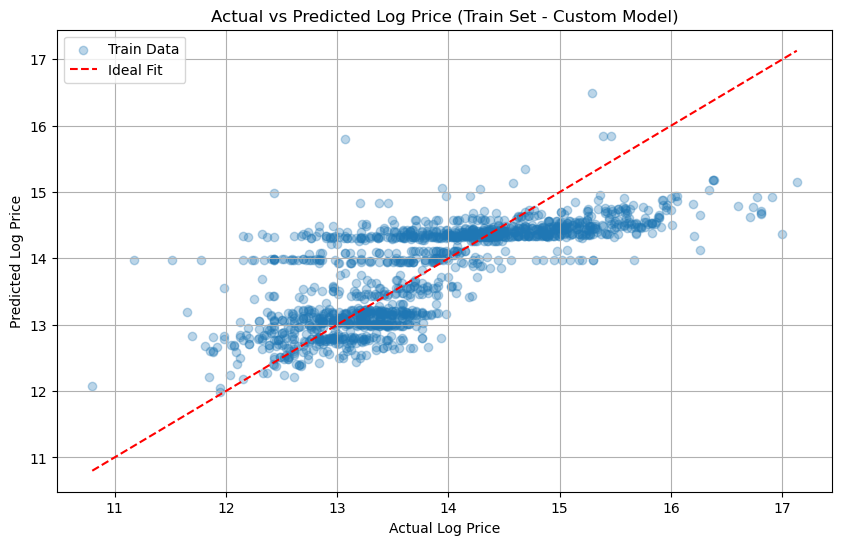

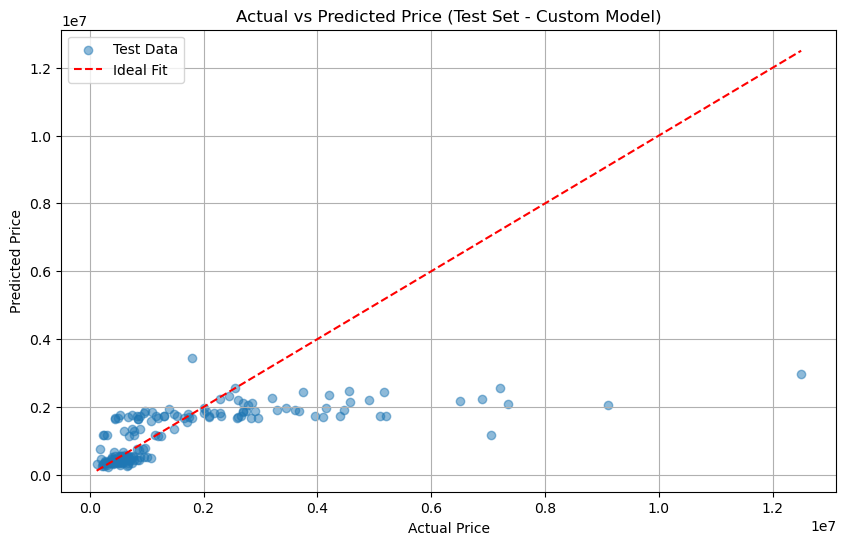


Script finished.


In [5]:
# --- Model Training using Custom LinearRegression ---
print("\nInitializing and fitting custom LinearRegression model...")
# Choose optimizer and hyperparameters
# Options: 'gradient_descent', 'sgd', 'mini_batch_gd', 'normal_equation', 'AdamOptimizer' (if Adam class exists)
# For gradient-based, adjust learning_rate and n_iterations
model = LinearRegression(
    optimizer='sgd', # Try 'normal_equation' if no regularization needed and data isn't too large
    learning_rate=0.003,         # May need tuning
    n_iterations=1000,          # May need tuning
    # regularization='l2',        # Optional: 'l1' or 'l2'
    # lambda_param=0.01,          # Regularization strength
    random_state=43,
    tol=1e-5,                   # Convergence tolerance
    max_iter=500                 # Early stopping patience
)

# Fit the model using scaled training data
model.fit(X_train_scaled, y_train, verbose=True) # Set verbose=True for training progress

# --- Prediction using Custom Model ---
print("\nPredicting on the test set...")
y_pred = model.predict(X_test_scaled)
# If y was scaled, inverse transform predictions:
# y_pred_unscaled = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
# y_test_unscaled = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

# --- Evaluation using Custom Metrics ---
print("\nEvaluating model performance...")

# Calculate metrics for Log_Price
# Use original y_test and predicted y_pred
mse_log = mean_squared_error(y_test, y_pred)
mae_log = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print weights and intercept from custom model
print("\nFeature weights:")
params = model.get_params()
weights = params.get('weights') # Use .get for safety
bias = params.get('bias')

if weights is not None and len(weights) == len(existing_features):
     # Sort features by absolute weight magnitude (optional)
     # feature_weights = sorted(zip(existing_features, weights), key=lambda item: abs(item[1]), reverse=True)
     # for feature, weight in feature_weights:
     #      print(f"{feature}: {weight:.8f}")

     # Or print in original order
     for feature, weight in zip(existing_features, weights):
         print(f"{feature}: {weight:.8f}")

     print(f"Intercept: {bias:.8f}")
else:
     print("Could not retrieve weights or feature length mismatch.")
     print(f"Number of features: {len(existing_features)}, Number of weights: {len(weights) if weights is not None else 'None'}")


# Print metrics for Log_Price
print("\nMetrics for Log_Price (Test Set):")
print(f"MSE: {mse_log:.4f}")
print(f"MAE: {mae_log:.4f}")
print(f"R^2: {r2:.4f}")

# --- Evaluation on Actual Price ---
print("\nCalculating metrics for Actual Price...")
# Inverse transform y_test and y_pred from log scale to actual price scale
# Use original y_test (which is Log_Price)
y_test_exp = np.exp(y_test)
y_pred_exp = np.exp(y_pred)

# Calculate metrics for Actual Price using custom functions
mse_actual = mean_squared_error(y_test_exp, y_pred_exp)
mae_actual = mean_absolute_error(y_test_exp, y_pred_exp)
# R^2 score on the exponentiated values might not be directly comparable or as meaningful
# It's often better to evaluate R^2 on the scale the model was trained on (log scale here)
# However, calculating it as requested:
r2_actual = r2_score(y_test_exp, y_pred_exp)

# Print metrics for Actual Price
print("\nMetrics for Actual Price (Test Set):")
print(f"MSE: {mse_actual:.4f}")
print(f"MAE: {mae_actual:.4f}")
print(f"R^2: {r2_actual:.4f}")


# --- Evaluation on Training Set ---
print("\nPredicting and evaluating on the training set...")
y_pred_train = model.predict(X_train_scaled)

# Metrics for Log Price (Train Set)
mse_train_log = mean_squared_error(y_train, y_pred_train)
mae_train_log = mean_absolute_error(y_train, y_pred_train)
r2_train_log = r2_score(y_train, y_pred_train)

print("\nMetrics for Log_Price (Train Set):")
print(f"MSE: {mse_train_log:.4f}")
print(f"MAE: {mae_train_log:.4f}")
print(f"R^2: {r2_train_log:.4f}")

# --- Visualization ---
print("\nGenerating plots...")

# Plot Learning Curve (if iterative optimizer was used)
if hasattr(model, 'plot_learning_curve') and model.optimizer.__class__.__name__ != 'NormalEquation':
     try:
         print("Plotting learning curve...")
         model.plot_learning_curve() # Call the method from the LinearRegression instance
         plt.savefig('custom_learning_curve.png')
         plt.show()
     except Exception as e:
         print(f"Could not plot learning curve: {e}")
else:
    print("Learning curve plot not available for Normal Equation optimizer or model lacks the method.")


# Visualize predictions vs actual (Log Scale - Train)
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_pred_train, alpha=0.3, label='Train Data')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', label='Ideal Fit')
plt.xlabel('Actual Log Price')
plt.ylabel('Predicted Log Price')
plt.title('Actual vs Predicted Log Price (Train Set - Custom Model)')
plt.legend()
plt.grid(True)
plt.savefig('custom_prediction_log_train.png')
plt.show()


# Visualize predictions vs actual (Actual Price Scale - Test)
plt.figure(figsize=(10, 6))
plt.scatter(y_test_exp, y_pred_exp, alpha=0.5, label='Test Data')
# Plot ideal fit line based on actual price range
min_price = min(y_test_exp.min(), y_pred_exp.min())
max_price = max(y_test_exp.max(), y_pred_exp.max())
plt.plot([min_price, max_price], [min_price, max_price], 'r--', label='Ideal Fit')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Price (Test Set - Custom Model)')
plt.legend()
plt.grid(True)
# Optional: Adjust axis limits if needed, e.g., plt.xlim(0, max_price * 1.1), plt.ylim(0, max_price * 1.1)
plt.savefig('custom_prediction_actual_test.png')
plt.show()

print("\nScript finished.")

# 3. Model Evaluation

In [ ]:
# --- Evaluation using Custom Metrics ---
print("\nEvaluating model performance...")

# Calculate metrics for Log_Price using functions from metrics.py
mse_log = mean_squared_error(y_test, y_pred)
mae_log = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# ... (Printing weights) ...

# Print metrics for Log_Price (Test Set)
print("\nMetrics for Log_Price (Test Set):")
print(f"MSE: {mse_log:.4f}")
print(f"MAE: {mae_log:.4f}")
print(f"R^2: {r2:.4f}")

# --- Evaluation on Actual Price ---
print("\nCalculating metrics for Actual Price...")
y_test_exp = np.exp(y_test)
y_pred_exp = np.exp(y_pred)

# Calculate metrics for Actual Price using functions from metrics.py
mse_actual = mean_squared_error(y_test_exp, y_pred_exp)
mae_actual = mean_absolute_error(y_test_exp, y_pred_exp)
r2_actual = r2_score(y_test_exp, y_pred_exp)

# Print metrics for Actual Price (Test Set)
print("\nMetrics for Actual Price (Test Set):")
print(f"MSE: {mse_actual:.4f}")
print(f"MAE: {mae_actual:.4f}")
print(f"R^2: {r2_actual:.4f}")

# --- Evaluation on Training Set ---
print("\nPredicting and evaluating on the training set...")
y_pred_train = model.predict(X_train_scaled)

# Metrics for Log Price (Train Set) using functions from metrics.py
mse_train_log = mean_squared_error(y_train, y_pred_train)
mae_train_log = mean_absolute_error(y_train, y_pred_train)
r2_train_log = r2_score(y_train, y_pred_train)

print("\nMetrics for Log_Price (Train Set):")
print(f"MSE: {mse_train_log:.4f}")
print(f"MAE: {mae_train_log:.4f}")
print(f"R^2: {r2_train_log:.4f}")


Evaluating model performance...

Metrics for Log_Price (Test Set):
MSE: 4148861795405634906576262138666513498401684076422362221845324117554179152078352477292694992773086269586780684623091335168.0000
MAE: 2036870968599514241763934317369814863137447446618079414452224.0000
R^2: -4576927829248721957384998141789119657315144132079452392539236628675574301798487068540134626654151770764558777451435524096.0000

Calculating metrics for Actual Price...

Metrics for Actual Price (Test Set):
MSE: inf
MAE: inf
R^2: -inf

Predicting and evaluating on the training set...

Metrics for Log_Price (Train Set):
MSE: 4146866325265389794124579647814159115514818620672480216767039104757444926228340015054402806338809903345600653828670095360.0000
MAE: 2036381473518512708858837585365502981075159164964413898752000.0000
R^2: -4262236283126895087175015316212613275041156894508794479245302435495240539004237654189099679146144512728676175436520095744.0000
